Link to notebook:

https://colab.research.google.com/drive/1hoj8HHFt1JOrgBXIIW6qiJ0u9OvOGrmK#scrollTo=i-v_l1OsGClb

# 1. PROJECT DESCRIPTION

4,764 workers died on the job in 2020 (3.4 per 100,000 full-time equivalent workers). Workers in transportation and material moving occupations and construction and extraction occupations accounted for nearly half of all fatal occupational injuries (47.4 percent), representing 1,282 and 976 workplace deaths, respectively.

*Occupational Safety and Health Administration (US Department of Labour)*

The above statistics highlight the need for more stringent protocols regarding the use of PPE in industrial settings. In this project, we develop an object detection model based on computer vision that detects Personal Protective Equipment (PPE) on workers within an industrial environment. Our model is capable of real time detection of vital safety gear on workers, which include hardhats, masks and safety vests. It addresses the issues of workplace safety by detecting safety equipment and helps reduce the risk of accidents and injuries at the workplace.

Our model is fine-tuned and based on a pre-trained YOLO model used for single-shot object detection, which uses a single pass of an input image to make predictions about the presence and location of the safety gear in the image. Various versions of YOLO are tested, and the medium COCO detection model of YOLOv8 is chosen to be fine-tuned for our project. The final model demonstrates strong performance for detecting safety gear in both images and videos. A simple illustration that shows how the model works:

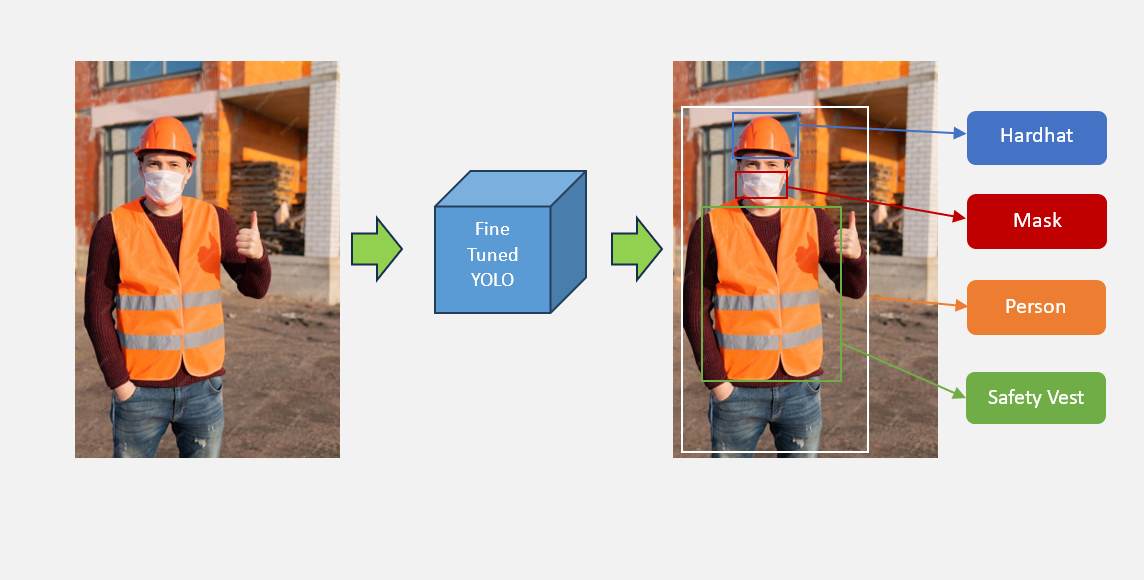


# 2. LIBRARIES & FUNCTIONS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install ultralytics --quiet
!pip install Pillow --quiet

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
from PIL import Image as ImagePIL
from IPython import display
import ultralytics
import yaml
import random
from IPython.display import Image,display
import glob
import cv2
from IPython.display import HTML
from base64 import b64encode

In [ ]:
#creating a function to count the number of labels in each set
def count_labels(directory):
    label_counts = {}
    for file in os.listdir(directory):
        if file.endswith('.txt'):
            filepath = os.path.join(directory,file)
            with open(filepath, 'r') as f:
                for line in f:
                    if line.strip():  # Checking if line is not empty
                        class_id = int(line.split()[0])
                        if class_id in label_counts:
                            label_counts[class_id] += 1
                        else:
                            label_counts[class_id] = 1
    return label_counts

In [ ]:
#counts number of images in each set
def count_dataset(directory):
    count = 0
    for file in os.listdir(directory):
        if file.endswith('.txt'):
            count = count + 1
    return count

In [ ]:
# Function to plot label counts for each set
def plot_separate_subplots(train, valid, test, labels):

    classes = [0, 1, 2, 3]
    train_vals = [train.get(c, 0) for c in classes]
    valid_vals = [valid.get(c, 0) for c in classes]
    test_vals = [test.get(c, 0) for c in classes]

    sns.set(style="whitegrid")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Train Set Plot
    sns.barplot(ax=axes[0], x=labels, y=train_vals, palette='Blues_d')
    axes[0].set_title('Train Set Label Counts')
    axes[0].set_xlabel('Class Labels')
    axes[0].set_ylabel('Counts')
    axes[0].tick_params(axis='x', rotation=45)

    # Validation Set Plot
    sns.barplot(ax=axes[1], x=labels, y=valid_vals, palette='Greens_d')
    axes[1].set_title('Validation Set Label Counts')
    axes[1].set_xlabel('Class Labels')
    axes[1].tick_params(axis='x', rotation=45)

    # Test Set Plot
    sns.barplot(ax=axes[2], x=labels, y=test_vals, palette='Reds_d')
    axes[2].set_title('Test Set Label Counts')
    axes[2].set_xlabel('Class Labels')
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

In [ ]:
#checking image sizes
def print_image_sizes(directory):
    count =0
    for file in os.listdir(directory):
        if count < 1:  # Limit to first 10 images
            filepath = os.path.join(directory, file)
            with ImagePIL.open(filepath) as img:
                print(f"Image {count+1}: Width = {img.width}, Height = {img.height}")
            count += 1
        else:
            break

In [ ]:
def plot_random_images_from_folder(folder_path, num_images=20):


    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]


    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # open and display the image using PIL
        img = ImagePIL.open(os.path.join(folder_path, file_name))

        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

# 3. DATA COLLECTION & PRE-PROCESSING


Source link: https://universe.roboflow.com/roboflow-universe-projects/construction-site-safety/dataset/27

This dataset consists of a collection of images with labels for the following classes: 'Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle'. We find these labels very useful in tracking and monitoring applications where people are required to wear PPE.

Since the purpose of our project is to only detect PPE in a workplace, we did not require all of the labels currently being used. So two scripts were written to clean the Label Annotaion txt files, which are already downloaded from the source link using the YOLOv8 format.



### 3.1 - Script 1 Removing unwanted labels

Note: These scripts were ran locally and not on this notebook. So the code will be commented out

In this dataset, each class is assigned a numerical identifier in the label text files. Originally, the classes were ordered as follows: 'Hardhat' (0), 'Mask' (1), 'NO-Hardhat' (2), 'NO-Mask' (3), 'NO-Safety Vest' (4), 'Person' (5), 'Safety Cone' (6), 'Safety Vest' (7), 'machinery' (8), and 'vehicle' (9).

 The labels to be removed: 'NO-Hardhat' (2),NO-Mask' (3), 'NO-Safety Vest' (4),'Safety Cone' (6), 'machinery' (8), and 'vehicle' (9).



In [ ]:
#import os
#
#def remove_labels(label_dir, class_ids_to_remove):
#    for filename in os.listdir(label_dir):
#        if filename.endswith('.txt'):
#            path = os.path.join(label_dir, filename)
#            with open(path, 'r') as file:
#                lines = file.readlines()
#            with open(path, 'w') as file:
#                for line in lines:
#                    if int(line.split()[0]) not in class_ids_to_remove:
#                        file.write(line)
#
#label_directory = '/Users/abdelrahmanghanayem/Desktop/UofT MEng/Fall 2023/MIE1517/Project/Datasets/Construction Site Safety.v27-yolov8.yolov8/valid/labels'  # Update with your path
#classes_to_remove = [2,3,4,6,8,9]  # Update with class IDs you want to remove
#
## Run the function
#remove_labels(label_directory, classes_to_remove)


###3.2 - Script 2 Reordering the Numbering of labels

Due to the removal of some labels, it was necessary to slightly adjust the numbering sequence of the remaining classes. This was run multiple times to convert each class label to the correct label.

In [ ]:
#import os

#def modify_labels(root_dir, original_label, new_label):
#    for subdir, dirs, files in os.walk(root_dir):
#        for filename in files:
#            if filename.endswith('.txt'):
#                filepath = os.path.join(subdir, filename)
#                with open(filepath, 'r') as file:
#                    lines = file.readlines()
#                with open(filepath, 'w') as file:
#                    for line in lines:
#                        parts = line.split()
#                        if parts[0] == str(original_label):
#                            parts[0] = str(new_label)
#                        file.write(' '.join(parts) + '\n')
#
#root_directory = '/Users/abdelrahmanghanayem/Desktop/UofT MEng/Fall 2023/MIE1517/Project/Datasets/Construction Site Safety.v27-yolov8.yolov8/valid/labels'
#
#Call the function to modify labels
#modify_labels(root_directory, original_label=7, new_label=6)

###3.3 - Loading the Dataset

The folder structure of a YoloV8 model should have the following format:

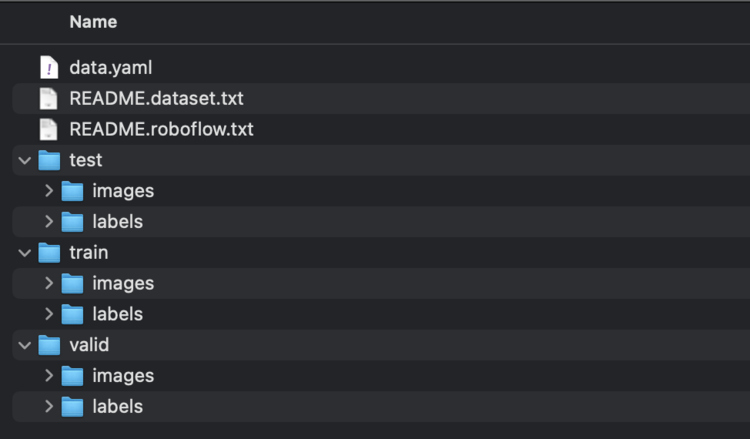

Each image file holds a collection of images designated for one of the following subsets: training, testing, or validation. Accompanying each of these image files is a corresponding label file, which comprises text files. Each text file contains annotations that are directly associated with each image in the set.

The data.yaml is a config file that gives informations for the training, such as the dataset path or the different segmentation of classes.

In [ ]:
train_dataset_path_images = '/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Rev2_Dataset/train/images'
test_dataset_path_images = '/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Rev2_Dataset/test/images'
valid_dataset_path_images = '/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Rev2_Dataset/valid/images'

train_dataset_path_labels = '/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Rev2_Dataset/train/labels'
test_dataset_path_labels = '/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Rev2_Dataset/test/labels'
valid_dataset_path_labels = '/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Rev2_Dataset/valid/labels'

train_dataset_path = '/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Rev2_Dataset/train/'
test_dataset_path = '/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Rev2_Dataset/test/'
valid_dataset_path = '/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Rev2_Dataset/valid/'

In [ ]:
train = count_dataset(train_dataset_path_labels)
valid = count_dataset(valid_dataset_path_labels)
test = count_dataset(test_dataset_path_labels)

# Print the counts
print(f'Train Images: {train}')
print(f'Validation Images: {valid}')
print(f'Test Images: {test}')

Summary:



*   Number of Classes: 4

*   Label Annotation format: YOLOv8 or YOLOv5

*   Total Images - Training: 1680, Val: 560 , Test: 559

*   Clases: [ 0: 'Hardhat', 1: 'Mask', 2: 'Person', 3: 'Safety Vest']





# 4. VISUALIZATION & DATA ANALYSIS

In [ ]:
#defining the number of classes and their names
num_classes = 4
classes = ['Hardhat', 'Mask', 'Person', 'Safety Vest']

In [ ]:
train_counts = count_labels(train_dataset_path_labels)
valid_counts = count_labels(valid_dataset_path_labels)
test_counts = count_labels(test_dataset_path_labels)

# Printing the counts
print(f'Train Label Counts: {train_counts}')
print(f'Validation Label Counts: {valid_counts}')
print(f'Test Label Counts: {test_counts}')

In [ ]:
#Ploting the counts
plot_separate_subplots(train_counts, valid_counts, test_counts, classes)

In [ ]:
#checking image size in train
print("Train data Image sizes")
print_image_sizes(train_dataset_path_images)

In [ ]:
plot_random_images_from_folder(train_dataset_path_images, num_images=20)

The reason behind every image being split into multiple images is due to the augmentations applied on the images. Based on the source of data from Roboflow, thhe following augmentation techniques were applied to this dataset.

1.  Flip: Horizontal
2.  Crop: 0% Minimum Zoom, 20% Maximum Zoom
3.  Rotation: Between -12° and +12°
4.  Shear: ±2° Horizontal, ±2° Vertical  
5.  Grayscale: Apply to 10% of images
6.  Hue: Between -15° and +15°
7.  Saturation: Between -20% and +20%
8.  Brightness: Between -25% and +25%
9.  Exposure: Between -20% and +20%
10.  Blur: Up to 0.5px
11. Cutout: 6 boxes with 2% size each
12. Mosaic: Applied


Every training example would have 4 outputs with different augmentations applied.




# 5. MODEL ARCHITECTURE / END-to-END PIPELINE

In 2015, Joseph Redmon and Ali Farhadi from the University of Washington developed a cutting-edge object detection system named YOLO (You Only Look Once). This algorithm surpassed the performance of other methods like R-CNN, Fast R-CNN variations, and DPM. Unlike techniques that use sliding windows or region proposals, YOLO processes the entire image at once during both training and testing. This approach helps it to inherently understand the context and appearance of different classes. The original YOLO version was adept at rapidly identifying objects in images, though it struggled with accurately pinpointing smaller objects. This limitation is a concern for just one of the classes in our study, as masks are the only small object we deal with in this project.

In our project we experimented with YOLOv5 and YOLOv8. We have shared an illustration of high-level architecture of YOLOv8 - which is a substantial improvement on the cutting-edge model known as YOLO. The new architecture splits into 2: head and backbone with 53 convolutional layers and a cross-stage partial connection. The medium model we used has ~25 million parameters (the specifics for each model is printed in their own sections). One of its key features is the self-attention mechanism. This helps the model decide which parts of the picture to focus on.

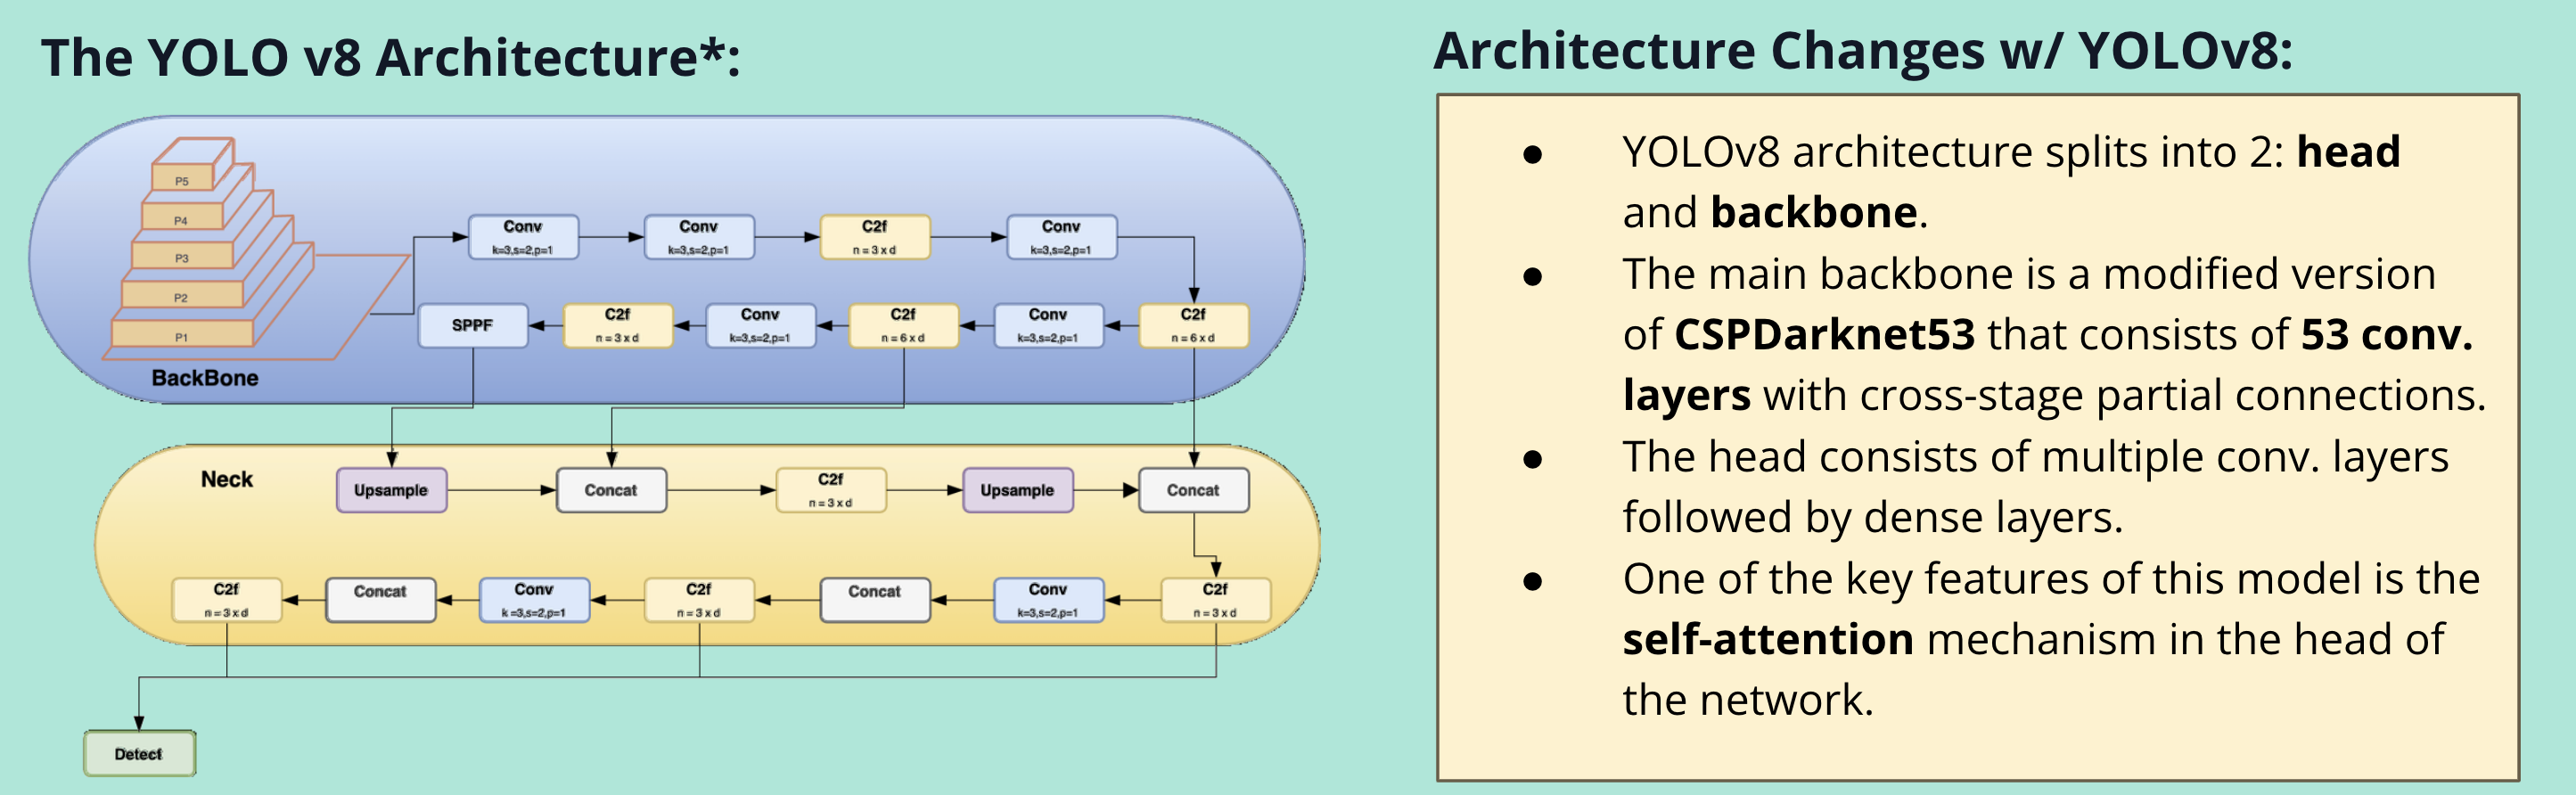

# 6. MODEL TRAINING & VALIDATION - QUANTITATIVE RESULTS

## 6.1 - YOLO v5

YOLOV5 is a predeccesor to YOLOV8. Although there have been versions in between (6 and 7), YOLOV5 remains as the most popular model used for research and deployments. For this reason, it is used as a benchmark for the performance of the new trained models.

An alternative would be to use MobileNetSSD as a benchmark since it is the most commonly used object detection alternative to YOLO. It is not selected for benchmarking however since the architecture is significantly simpler and has demonstrated worse results on many standard sets including MNIST, CIFAR, etc.

Research on YOLO optimizations has indicated that the latest model may not always perform the best for a given dataset, so that is why it is important to test against other YOLO models.

In [ ]:
# YOLOV5 Section

# YOLOV5 is being used as a comparison model.

# clone the repo and import neccesary libraries
!git clone https://github.com/ultralytics/yolov5 \
%cd /content/yolov5
!ls

import torch
from IPython.display import Image  # for displaying images
print('Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

In [ ]:
%cd /content/yolov5/

# update the paths to match your dataset

train_data_yaml_path - "/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV5/Rev2_Dataset/data.yaml"

# note, the YOLOV5 small configuration is used for the benchmark to assess initial performance
config_file_path - "/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV5/Rev2_Dataset/custom_yolov5s.yaml"



!python train.py --img 640 --epochs 30 --data train_data_yaml_path --cfg config_file_path --weights ''

In [ ]:
# show the tensorboard results.

# results based on metric of choice discussed below.

%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
# test the performance of the model on the test images

test_data_path = "/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV5/Rev2_Dataset/test/images"

%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/exp4/weights/best.pt --img 640 --conf 0.4 --source test_data_path


In [ ]:
#display inference on all test images
from IPython.display import Image, display

for i, imageName in enumerate(glob.glob("/content/yolov5/runs/detect/exp3/*.jpg")): #assuming JPG
  if i == 50:
      break
  display(Image(filename=imageName))
  print("\n")

The results are created at the end of testing and shown in the output above.
The results we were able to achieve are shown here.

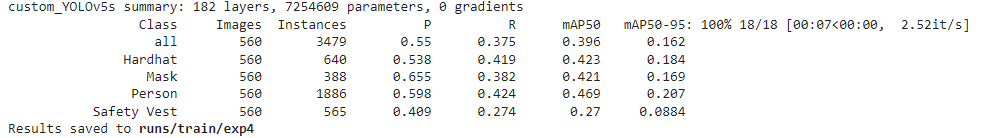

In this case, the YoloV5 model with default parameters performs much worse than YoloV8. It achieves significantly lower mAP50 and mAP5-95 (0.396 and 0.162, respectively).

This is based just on the mAP metrics and losses. Overall, the YoloV8 is selected
to continue based on two primary reasons:

1. YoloV8 has significantly less FLOPs and executes/infers faster
2. Qualitative/visual analysis and quantitative metrics of the printed images shows that the V8 model performs
better.

Tuning is not done on the V5 model since the initial investigation has shown
that V8 will give similar but faster performance.

## 6.2 - YOLO v8

### 6.2.1 - YOLOv8 without fine-tuning


In [ ]:
model = YOLO('/content/drive/My Drive/MIE1517_Project/yolov8n-oiv7.pt')

In [ ]:
results = model.predict(source = test_dataset_path_images, save = True, show=True, save_txt = True)

In [ ]:
for i, imageName in enumerate(glob.glob('/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Results/predict_pretrained/*.jpg')): #assuming JPG
    if i == 10:
        break
    display(Image(filename=imageName))
    print("\n")

The pre-trained YOLO v8 model used is originally trained on the Open Images V7 dataset. This dataset was developed by Google and is a treasure trove for computer vision research. It consists of around 9 million images annotated in various ways that make it one of the most comprehensive datasets available. The model after training on the dataset consists of loaded weights that recognize a wide range of objects and understand complex visual relationships. The model benefits from a vast array of image-level labels, bounding boxes and other annotations that cover an impressive 600 object classes. The knowledge the model gained from the dataset is tested on our images to see how it would perform for PPE detection. The results give us a first look at how well the model works with our data.

The images we show are randomly picked from our predictions, they help us understand how the model interprets PPE in different situations. However, we notice that the model isn't perfect for our dataset. It was originally trained on a different dataset, so the labels used do not align with the purpose of this project. Therefor this does not show us anything other than just a sample of how the outputs would look like when implementing a Yolo model.

### 6.2.2 - YOLOv8 with Custome Labels

Previously, we showed an example of one pre-trained model of Yolov8, but there are multiple available models that were trained on different datasets and also different model architectures.

There are five models in each category of YOLOv8 models for detection, segmentation, and classification. YOLOv8 Nano is the fastest and smallest, while YOLOv8 Extra Large (YOLOv8x) is the most accurate yet the slowest among them.

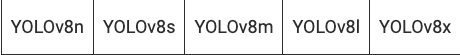


The pre-trained models are split into the following tasks:
1. Detection
2. Classification
3. Segmentation
4. Pose



Reference: https://learnopencv.com/ultralytics-yolov8/


We will only be using the detection models in this report since our purporse here is the detection and indetification of PPE equipment

#### 6.2.2.1 - Model Training with Default Hyperparameters

Using a pre-trained model weights as is and further training it on our dataset is extremely beneficial here since The pre-trained model has already learned to identify certain patterns and features in images, so it brings that knowledge into the new training process.

4 pre-trained models will be tested and one will be chosen to further fine-tune using some hyperparamter tuning.

The following models will be tested for training:

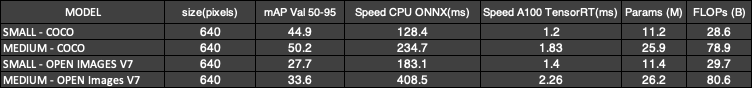

##### Model 1 - Small COCO Detection Model

In [ ]:
data = dict(train = train_dataset_path,
                    val = valid_dataset_path,
                    test = test_dataset_path,
            nc = len(classes),
            names = classes)

with open('/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Rev2_Dataset/data.yaml', 'w') as output:
    yaml.dump(data, output, default_flow_style = True)

model_1 = YOLO('/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Models/yolov8s.pt')

In [ ]:
model_1.train(data = "/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Rev2_Dataset/data.yaml", epochs = 30, imgsz = 640)

##### Model 2 - Medium COCO Detection Model

In [ ]:
model_2 = YOLO('/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Models/yolov8m.pt')

In [ ]:
model_2.train(data = "/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Rev2_Dataset/data.yaml", epochs = 30, imgsz = 640)

##### Model 3 - Small OpenImages V7 Detection Model

In [ ]:
model_3 = YOLO('/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Models/yolov8s-oiv7.pt')

In [ ]:
model_3.train(data = "/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Rev2_Dataset/data.yaml", epochs = 30, imgsz = 640)

##### Model 4 - Medium OpenImages V7 Detection Model

In [ ]:
model_4 = YOLO('/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Models/yolov8m-oiv7.pt')

In [ ]:
model_4.train(data = "/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Rev2_Dataset/data.yaml", epochs = 30, imgsz = 640)

#### 6.2.2.2 - Result Analysis

In [ ]:
best =  "/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Results/train_model_2/weights/best.pt"
best_model = YOLO(best)

In [ ]:
#checking validation result metrics on best model
metrics = best_model.val(split='val')
metrics.results_dict

Our validation results are consistent with the training and do not showcase any signs of overfitting, as also observed from the performence metric plots.

The best model from the COCO medium training will be used for further tuning. Yolov8 train function automatically outputs the weights of the last epoch in the training and the weights of the best epoch. This best epoch is chosen based on the fittness of the model. Fitness in our case was calculated to be 0.615. We also made sure the best model chose by YOLO based on fitness also aligns with the best mdoel based on the mAP50 metric we chose.

Fitness is a metric calculated based on a weighted combination of metrics.
This is the code used for calculation of fitness, gathered from the Ultralytics website.

    def fitness(self):
    """Model fitness as a weighted combination of metrics."""
       w = [0.0, 0.0, 0.1, 0.9]  # weights for [P, R, mAP@0.5, mAP@0.5:0.95]
       return (np.array(self.mean_results()) * w).sum()

reference: https://docs.ultralytics.com/reference/utils/metrics/#ultralytics.utils.metrics.Metric.fitness




In [ ]:
#Running the model on the validation set and dislaying the results
val_results = best_model.predict(source=valid_dataset_path_images, save = True, show=True, save_txt = True)

In [ ]:
for i, imageName in enumerate(glob.glob('/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Results/Images_videos_output/Valid/predict/*.jpg')): #assuming JPG
  if i == 15:
      break
  display(Image(filename=imageName))
  print("\n")

The model with default hyperparameters does a great job with the random validation test samples to highlight use of PPE equipment. We will now explore hyperparameter tuning to see how much improvement we can see with this model.

**Training times:**
- COCO Small: 0.27 hours
- COCO Medium: 0.563 hours
- OI v7 Small : 0.283 hours
- OI v7 Medium: 0.555 hours

In [ ]:
#reading csv result files for each model
model_1_results = pd.read_csv('/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Results/train_model_1/results.csv')
model_2_results = pd.read_csv('/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Results/train_model_2/results.csv')
model_3_results = pd.read_csv('/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Results/train_model_3/results.csv')
model_4_results = pd.read_csv('/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Results/train_model_4/results.csv')

#Adding model names
model_1_results["Model"]  = "Small COCO"
model_2_results["Model"]  = "Medium COCO"
model_3_results["Model"]  = "Small OpenImages"
model_4_results["Model"]  = "Medium OpenImages"


results = pd.concat([model_1_results, model_2_results, model_3_results, model_4_results], ignore_index=True) #concat
results = results[['Model'] + [col for col in results.columns if col != 'Model']] #moving "Model" column to first index
results.columns = results.columns.str.replace(' ', '')   #removing spaces from column names

In [ ]:
results.sort_values(by = ['metrics/mAP50(B)'], ascending=False, inplace=True)
results

These results are as expected from the pre-trained models performance metrics. **COCO with a medium sized architicture** resulted in the best performance. This model will be our final model to be tuned further to improve its performance.  




In [ ]:
print("Results for Model 2 - MEDIUM COCO ")
Image('/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Results /train_model_2/results.png', width=1000, height=500)

**Metric Explanations and Definitions:**

1. train or val /box_loss: This is the loss associated with the bounding box predictions during training and validation. It measures how well the model predicts the location and size of the boxes compared to the ground truth.

2. train or val / cls_loss: The classification loss during training and validation. It measures how well the model classifies objects within the bounding boxes.

3. train or val /dfl_loss: This refers to the "Distribution Focal Loss", which is a type of loss function that focuses on hard-to-classify examples and is used for classification within the bounding boxes.

4. metrics/precision(B):Precision is the ratio of correctly predicted positive observations to the total predicted positives. High precision relates to a low false positive rate.

5. metrics/recall(B): Recall is the ratio of correctly predicted positive observations to all actual positives. High recall relates to a low false negative rate.

6. metrics/mAP50(B): Mean Average Precision at 50% Intersection Over Union (IoU). This metric evaluates the model's object detection accuracy at a specific IoU threshold (50% in this case).

7. metrics/mAP50-95(B): Mean Average Precision calculated over multiple IoU thresholds, from 0.5 to 0.95 (inclusive) in steps of 0.05. It's an average of the mAP calculated at each of these thresholds.

8. lr/pg0, lr/pg1, lr/pg2: These are likely referring to learning rates for different parameter groups in the optimizer. In some training setups, different parts of the model might have different learning rates for fine-tuning purposes.

We chose mAP50 as our evaluation metric because we think its a suitable metric for evaluating a PPE detection model as it accounts for localization accuracy, balances precision and recall, accommodates different localization strictness levels, supports multi-class evaluation, and aligns with real-world safety requirements. It provides a comprehensive and interpretable assessment of a PPE detection model's performance.

In [ ]:
Image("/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Results/train_model_2/F1_curve.png", width=1000, height=450)

This F1-Confidence Curve graphically represents the performance of an object detection model across various classes. Each curve corresponds to a different class, such as 'Hardhat' or 'Mask', showing how the F1 score—a measure combining precision and recall—varies with different confidence thresholds. A peak in a curve indicates the threshold where the model's predictions reach their optimal balance between precision and recall for that class. The blue curve aggregates the performance across all classes, with a marked optimal point at an F1 score of 0.81 for a confidence threshold of 0.372. This suggests that at this threshold, the model achieves the best overall trade-off between precision and recall for all considered classes. Differences in curve shapes and peak locations highlight varying performance across classes, providing insights into model strengths and potential areas for improvement.

In [ ]:
Image("/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Results/train_model_2/confusion_matrix_normalized.png", width = 1000, height = 600)

The image shows a normalized confusion matrix for our model. It depicts how well the model predicts various classes such as 'Hardhat', 'Mask', 'Person', and 'background'. The matrix's rows represent the predicted classes, while the columns show the true classes. The diagonal cells, which represent correct predictions, are shaded according to the proportion of correct predictions in that class, with darker shades indicating higher proportions. For instance, 'Mask' has a high diagonal value of 0.84, suggesting that the model accurately predicts 'Mask' 84% of the time. Off-diagonal cells show misclassifications, like "Hardhat' being incorrectly predicted as 'Person' 2% of the time. This matrix is useful for identifying which classes are often confused by the model, which can inform further model training and refinement.

### 6.2.3 - HYPERPARAMETER TUNING

The method of tuning we will be using the class "ultralytics.engine.tuner.Tuner". As stated in thier website this class does the following:

"The class evolves YOLO model hyperparameters over a given number of iterations by mutating them according to the search space and retraining the model to evaluate their performance."

The model.tune() function does the following:

1. Load the existing hyperparameters or initialize new ones.
2. Mutate the hyperparameters based on the hyperparam space
3. Train a YOLO model with the mutated hyperparameters.
4. Log the fitness score and mutated hyperparameters to a CSV file.

In [ ]:
#Printing current Default Hyperparameters
desired_keys = [
    'lr0', 'lrf', 'momentum', 'weight_decay', 'warmup_epochs', 'warmup_momentum',
    'box', 'cls', 'dfl', 'hsv_h', 'hsv_s', 'hsv_v', 'degrees', 'translate',
    'scale', 'shear', 'perspective', 'flipud', 'fliplr', 'mosaic', 'mixup',
    'copy_paste' ]

with open("/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Results/train_model_2/args.yaml", "r", encoding="utf-8") as file:
  param = yaml.load(file, Loader=yaml.FullLoader)

param_default= {}
print('Default Hyperparameters:\n')
for key in desired_keys:
    if key in param:
        value = param[key]
        param_default[key] = value
        print(f'{key}: {value}')

Below is the search space used by the tuner when running the tuning function

In [ ]:
#The search space used by the tuner
param_grid = {'lr0': (1e-5, 1e-1),
              'lrf': (0.0001, 0.1),  # final OneCycleLR learning rate (lr0 * lrf)
              'momentum': (0.5, 0.98, 0.3),  # SGD momentum/Adam beta1
              'weight_decay': (0.0, 0.001),  # optimizer weight decay 5e-4
              'warmup_epochs': (0.0, 7.0),  # warmup epochs (fractions ok)
              'warmup_momentum': (0.0, 0.95),  # warmup initial momentum
              'box': (1.0, 20.0),  # box loss gain
              'cls': (0.2, 5.0),  # cls loss gain (scale with pixels)
              'dfl': (0.4, 6.0),  # dfl loss gain
              'hsv_h': (0.0, 0.1),  # image HSV-Hue augmentation (fraction)
              'hsv_s': (0.0, 0.9),  # image HSV-Saturation augmentation (fraction)
              'hsv_v': (0.0, 0.9),  # image HSV-Value augmentation (fraction)
              'degrees': (0.0, 45.0),  # image rotation (+/- deg)
              'translate': (0.0, 0.9),  # image translation (+/- fraction)
              'scale': (0.0, 0.95),  # image scale (+/- gain)
              'shear': (0.0, 10.0),  # image shear (+/- deg)
              'perspective': (0.0, 0.001),  # image perspective (+/- fraction), range 0-0.001
              'flipud': (0.0, 1.0),  # image flip up-down (probability)
              'fliplr': (0.0, 1.0),  # image flip left-right (probability)
              'mosaic': (0.0, 1.0),  # image mixup (probability)
              'mixup': (0.0, 1.0),  # image mixup (probability)
              'copy_paste': (0.0, 1.0)}

In [ ]:
model_best = YOLO("/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Results/train_model_2/weights/best.pt")

In [ ]:
#Tuning trial one with 20 iterations
best_parameters = model_best.tune(data='/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Rev2_Dataset/data.yaml', epochs= 20, iterations= 20, optimizer='auto', plots=True, save=True, val=True)

In [ ]:
#Tuning trial 2 with 10 iterations
best_parameters = model_best.tune(data='/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Rev2_Dataset/data.yaml', epochs=20, iterations=10, optimizer='auto', plots=True, save=True, val=True)

We are running an evolutionary hypertuning algorithm which is quite resource intensive. We have capped the iterations at 20 but because of the limited units available on colab, we were only able to reach up to 12 iterations.

We did run the tuning multiple times, with the first trial resulting in the better model.

In [ ]:
best_tuned =  YOLO("/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Results/runs/detect/tune/weights/best.pt")

In [ ]:
Image('/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Results/runs/detect/tune/tune_fitness.png', width=1000, height=500)

This plot shows the best fitness of each iteration ran during the hyperparameter tuning. As you can see, the best model was achieved at iteration 8.

In [ ]:
#checking all metrics of best model after hyper param tuning vs best model before hyper param tuning
metrics_tuned = best_tuned.val(split='val')
metrics_tuned.results_dict

In [ ]:
#saving tuned parameters in a dictionary
with open("/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Results/runs/detect/tune/best_hyperparameters.yaml", "r", encoding="utf-8") as file:
  param_tuned = yaml.load(file, Loader=yaml.FullLoader)

print('Tuned Hyperparameters:\n')
for key, value in param_tuned.items():
  print(f'{key}: {value}')

In [ ]:
#comparing default and Tuned hyperparams

df1 = pd.DataFrame.from_dict(param_tuned, orient='index', columns=['Tuned'])
df2 = pd.DataFrame.from_dict(param_default, orient='index', columns=['Default'])

# Concatenate DataFrames horizontally (along columns) based on the index
result_df = pd.concat([df1, df2],axis=1)
result_df

In the tuned model, several hyperparameters have been adjusted from their default settings, which has led to a slight improvement in the model's performance. The learning rate (lr0) and its final value (lrf) have been fine-tuned to be slightly lower than the defaults, which may have allowed for more precise adjustments to the model weights during training. The momentum, which helps accelerate gradients in the right direction, has been reduced, potentially leading to more stable updates. The warmup epochs, which control the number of epochs before learning rate scheduling starts, have been decreased, suggesting a faster transition to the main learning rate schedule. Warmup momentum has also been reduced, allowing for a less aggressive buildup of momentum at the start of training.

Significant changes are observed in augmentation parameters like hue, saturation, and value adjustments in the HSV color space (hsv_h, hsv_s, hsv_v), which have been lowered. This may suggest that the tuned model requires less aggressive color augmentation to learn effectively. The fliplr (flip left/right) parameter has been adjusted close to its default value, while other geometric augmentations like degrees, translate, scale, shear, perspective, flipud (flip up/down), mosaic, mixup, and copy_paste remain unchanged, indicating that the default settings for these were already optimal or not influential in this context.

In [ ]:
df1 = pd.DataFrame.from_dict(metrics.results_dict, orient='index', columns=['Default Model'])
df2 = pd.DataFrame.from_dict(metrics_tuned.results_dict, orient='index', columns=['Tuned Model'])

# Concatenate DataFrames horizontally (along columns) based on the index
metrics_df = pd.concat([df1, df2],axis=1)
metrics_df

Based on the tuning results, iteration 8 resulted in the best fittness and mAP 50 of all iterations tested, 0.65464 and 0.864 respectively. Compared to the 0.61 and 0.84 obtained earlier, there is a 7% improvement in model fittness and about 3% improvement in mAP50.

Overall, the fine-tuning of these parameters has likely resulted in a training process that is more controlled and gradual, avoiding drastic changes to the model that could lead to overfitting, and therefore enhancing the model's ability to generalize from the training data to unseen data.

In [ ]:
# Load the two images
from PIL import Image
import numpy as np
image1 = Image.open('/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Results/train_model_2/results.png')
image2 = Image.open('/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Results/runs/detect/train8/results.png')

# Convert the images to numpy arrays
image1_array = np.array(image1)
image2_array = np.array(image2)

# Create a figure and add the two images as subplots
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.imshow(image1_array)
ax2.imshow(image2_array)
ax1.set_title("Without Tuning")
ax2.set_title("With Tuning")
ax1.axis('off')
ax2.axis('off')
fig.set_size_inches(15,15)
plt.show()

# Show the figure
plt.show()

Post-tuning, the model shows lower training and validation losses, indicating better generalization and learning efficiency. The mean Average Precision (mAP) at various Intersection over Union (IoU) thresholds and the losses start at higher and lower points respectively compared to the training with the default parameters. The reason behind that is because we took the the best weights out of the first batch of training while using only the default paramaters. Then those best weights were further tuned used different iterations of hyperparameters. This approach is a form of iterative training and is often used to fine-tune models by making adjustments based on the performance observed in initial training rounds.


mAP drops intially but then continues rising to a point where it achieved better performance compared to the default parameters. Overall, these improvements suggest that hyperparameter tuning has made the learning process more stable and the model more reliable in its predictive performance.


#7. QUALITATIVE RESULTS / NEW DATA IMPLEMENTATION

In [ ]:
metrics_tuned_test = best_tuned.val(split='test')
metrics_tuned_test.results_dict

These results match the results obtained above from the validation and training set, which tells us the model is not overfitting and generalizes well with unseen data.

In [ ]:
best_tuned.predict(source = test_dataset_path_images, save = True, show=True)

In [ ]:
for i, imageName in enumerate(glob.glob('/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Results/Images_videos_output/Test/predict2/*.jpg')): #assuming JPG
  if i == 50:
      break
  display(Image(filename=imageName))
  print("\n")

Testing the model on a seperate set of images gathered online.

In [ ]:
best_tuned.predict(source = "/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/test_images", save = True, show=True)

In [ ]:
for i, imageName in enumerate(glob.glob('/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Results/Images_videos_output/test_other/predict2/*.jpg')): #assuming JPG
  if i == 30:
      break
  display(Image(filename=imageName))
  print("\n")

In [ ]:
best_tuned.predict(source = "/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Results/Images_videos_output/helmet_held.jpeg", save = True, show=True)

In [ ]:
display(Image("/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Results/runs/detect/predict2/helmet_held.jpeg"))

Link below is a folder containing all image output from our model.

https://drive.google.com/drive/folders/1F_HCjoWy_sC22PEZ4Zb10BlVzR-ZbXEa


1- Can easily detect when a person faces the camera with no objections.

2- Detects random objects as "person".

3- Unable to detect some safety vests with different colors.

4- Unable to detect hardhats when not worn on head.

5- Unable to detect small objects at longer distances, as observed in the pictures below, where the mask was only detected when the person was close.

6- Overall good model performance but with a some snags to be discussed later in the Discussion section.



Examples:

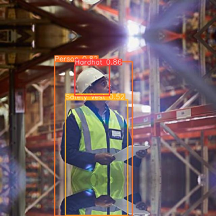


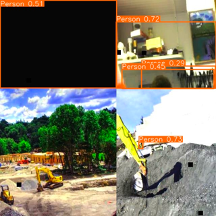

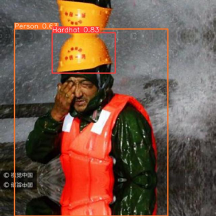

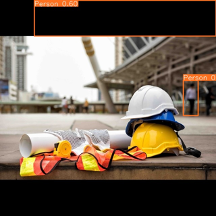

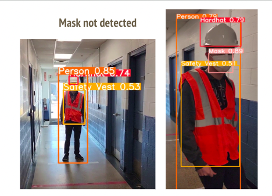

Testing a few videos collected by us. These videos were taken at one of the group member's workplace.

Desciption:
- 36 Video Samples
- 5 people - 3 men + 2 women, some with multiple people
- 2 Environments
- Varying colors and types of PPE

Only a few of videos will be presented here


In [ ]:
model_weights = "/content/drive/MyDrive/MIE1517_Project/Datasets/YoloV8/Results/tuning_10_iterations/detect/tune/weights/best.pt"

In [ ]:
video_directory = '/content/drive/MyDrive/MIE1517_Project/Testing Data/Person 1/'

for video_file in glob.glob(os.path.join(video_directory, '*.mp4')):
    best_tuned.predict(video_file, save=True, save_frames = True)

In [ ]:
video_directory = '/content/drive/MyDrive/MIE1517_Project/Testing Data/Person 2/'

for video_file in glob.glob(os.path.join(video_directory, '*.mp4')):
    best_tuned.predict(video_file, save=True, save_frames = True)

In [ ]:
video_directory = '/content/drive/MyDrive/MIE1517_Project/Testing Data/Person 3/'

for video_file in glob.glob(os.path.join(video_directory, '*.mp4')):
    best_tuned.predict(video_file, save=True, save_frames = True)

In [ ]:
video_directory = '/content/drive/MyDrive/MIE1517_Project/Testing Data/Person 4/'

for video_file in glob.glob(os.path.join(video_directory, '*.mp4')):
    best_tuned.predict(video_file, save=True, save_frames = True)

In [ ]:
video_directory = '/content/drive/MyDrive/MIE1517_Project/Testing Data/Person 5/'

for video_file in glob.glob(os.path.join(video_directory, '*.mp4')):
    best_tuned.predict(video_file, save=True, save_frames = True)

Output of all these videos along with their frames can be found here:

https://drive.google.com/drive/folders/1i1XJ9FuEmx777Y8VGAWBkVHvJqoKdGZI

# 8. RELATED WORK

We compared our best model with a state-of-the-art model [1], that uses a tuned YOLOv5x model to achieve the best performance on a separate dataset they created for their study. Their paper discusses the development of advanced PPE detection systems focusing on the You Only Look Once (YOLO) architectures. The authors have trained and evaluated eight different YOLO-based detectors across six classes which include four helmet colors of red, blue, yellow and white, persons, and vests.

In comparison, our model detects 4 classes of hardhats, safety vests, masks and persons. Our model is capable of detecting an extra ‘Mask’ class, this is a unique feature of our model. For the ‘Hardhat’ class, we compared our results to theirs by averaging their precision scores across the different color classes of their model to create a single score. For the 'Vest' and 'Person' classes, we compared the scores directly as these categories were consistent between both models. The average of their precision scores are calculated based on all of their 6 classes, and represents the best mAP score that they obtained. A comparison of the precision scores for each class along with the average is shown in the table below.






| Class   | Our best model | YOLOv5x[1]      |
|---------|----------------|--------------|
| Hardhat | 0.84           | 0.88         |
| Vest    | 0.802          | 0.814        |
| Mask    | 0.926          | None         |
| Person  | 0.889          | 0.843        |
| mAP     | 0.864          | 0.865        |


Our model compared with a state-of-the-art model shows promising results as the mAP scores achieved by both of the best models are nearly identical, and our model takes into account an extra ‘Mask’ class as well which is absent from their study. To conclude, our model demonstrates strong performance across its classes and is competitive with existing state-of-the-art models.

[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8156681/

# 9. DISCUSSION

As the model is not perfect - we have run into a few challenges & also discovered some problems as we analyzed our results. Below are top issues that were identified with the detection results:

**Issues in detection**
- Cannot detect certain PPEs at longer distances
- Model confuses a lot of parts as ”person”
- Bad training data annotation
- Does not detect all types of safety vests
  - YOLO models struggles with detection of small objects
- Leads to detection issues combined with smaller count of “mask” objects in our data.

Reasons for these issues:

- YOLO models, as mentioned before, generally struggles with smaller objects. In a video feed, when a person is far away, objects are even smaller than most of the training/validation data we have. Which leads the model to struggle with precise detection when objects are far away.

- On top of the distance to the camera, one of our classes (masks) is a small object. To exacerbate the issue, there were not many training data available for masks compared to the other classes.

- Annotation quality of the dataset can be improved, especially for the "Person" class. The subpar annotation of Persons classes was one of the leading reasons that resulted in the model occasionally identifying unrelated objects as Persons.


--------------------------------------------------------------------------------


**Lessons Learned:**
- Data Quality & Variety
  - The quality of data is crucial in YOLOv8 models, as high-quality, diverse, and accurately annotated datasets are essential for the model to learn effective and reliable object detection across various scenarios.
- The Power of Pretrained Models:
  - Leveraging pretrained models as a starting point can significantly boost the training efficiency and performance of a model.
- Computational Resources
  - Colab Limits resources so it makes it hard to train. Time to train is very long, specially for hyperparameter tuning.


**Future improvements:**

As we implemented the model, we realized that there were cases of objects being "in frame" but not being "on person". This is not good as these objects would be identified but it's not helping our goal - which is to increase the "usage of PPEs." To address this we have considered and even implemented some solutions.
*   The initial solution we looked at was adding a class of "Head with No Hat", and "Torso with No Vest" classes, for when these objects were in frame but not on person. However, this quickly made our results even more cluttery and impossible to read as the number of individuals in-frame increased. This would have made this solution very impractical in factory-floor video feed environments where you might have multiple people in frame at any given time. Thus, we have excluded it from our final build of the model.
*   The second solution we considered, but not implemented, is to build a secondary classification model on top of the results from our object detection model. The model would look at the coordinates, height, and width of the bounding boxes for each objects and ensure the PPE bounding boxes would be at the right coordinates based on the Person. This is a problem equally as challenging as the PPE identification. The primary challenge stems from the fact that a Person can be standing, sitting, leaning, etc. Furthermore, in terms of Fairness & Ethics stand-point there are additional concerns. Different genders have different body proportion, and there are even some people with disabilities that the model would struggle with identifying. Therefore, this would be a challenging but exciting second part of the project.
